In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Keras uses TensforFlow backend as default
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv1D,UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
import tensorflow as tf

import keras
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
import keras.layers as layer
from keras import backend as K

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1,28*28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.


In [ ]:
x_train_  = np.expand_dims(x_train, 1)

In [ ]:
x_test_  = np.expand_dims(x_test, 1)

In [ ]:
h_size = 4
z_dims = 5
input_img =  keras.Input(shape=(1, 28*28))

def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(z_dims, ))
    return mu + K.exp(log_var / 2) * eps

def Encoder(input_img):

    # Encoder
  
    traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(input_img)
    traj_input = layer.MaxPool1D(4, padding = 'same')(traj_input)
    traj_input = layer.Conv1D(1, 3, activation = 'relu', padding = 'same')(traj_input)
    traj_input = layer.MaxPool1D(4, padding = 'same')(traj_input)
    traj_input = layer.Flatten()(traj_input)

    # Sampling

    z_mean = layer.Dense(z_dims, activation='tanh')(traj_input)
    z_var_log = layer.Dense(z_dims, activation='linear')(traj_input)
    # z_var = tf.exp(z_var_log) + 1e-20
    # eps = K.random_normal(shape =(z_dims,), mean=0., stddev=1.0, dtype=tf.float32)
    # z = tf.add(z_mean, tf.multiply(tf.sqrt(z_var), eps))
    z = Lambda(sample_z, output_shape=(z_dims,))([z_mean, z_var_log])
    enc = keras.Model(input_img, [z_mean, z_var_log, z], name="encoder")
    return enc, z_mean, z_var_log

z_input =  keras.Input(shape=(z_dims,))

def Decoder (z_input):
    # Decoder
    z_traj_input = layer.Dense(50)(z_input)
    z_traj_input = layer.Reshape((25, 2))(z_traj_input)
    z_traj_input = layer.Conv1D(h_size, 3, activation = 'relu', padding = 'same')(z_traj_input)
    c = layer.UpSampling1D(2)(z_traj_input)
    z_traj_input =   layer.UpSampling1D(2)(z_traj_input) #layer.Conv1D(2, 1, activation = 'relu', padding = 'same')(z_traj_input)
    z_traj_input = layer.Flatten()(z_traj_input)
    z_traj_input = layer.Dense(28*28, activation='sigmoid')(z_traj_input)
    traj_hat = layer.Reshape((1, 28*28))(z_traj_input)
    dec= keras.Model(z_input, traj_hat, name="decoder")
    return dec

In [ ]:
Encd, mu, log_var  =  Encoder(input_img)

In [ ]:
z_input =  keras.Input(shape=(z_dims,))
Decd  =  Decoder(z_input)

In [ ]:
output = Decd(Encd(input_img)[2:])

In [ ]:
output.shape

TensorShape([None, 1, 784])

In [ ]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
vae = Model(input_img, output)
vae.summary()
vae.compile(optimizer='adam', loss=loss_func(mu, log_var), metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 784)]          0         
                                                                 
 encoder (Functional)        [(None, 5),               9445      
                              (None, 5),                         
                              (None, 5)]                         
                                                                 
 decoder (Functional)        (None, 1, 784)            157912    
                                                                 
Total params: 167,357
Trainable params: 167,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train_[0:1000,:].shape

(1000, 1, 784)

In [ ]:
# train
vae.fit(x_train_, x_train_, 
       shuffle=True,
       epochs=10,
       batch_size=64,
       verbose=1)

Epoch 1/100
938/938 [==============================] - 17s 16ms/step - loss: 75.3893 - accuracy: 0.0104
Epoch 2/100
938/938 [==============================] - 15s 16ms/step - loss: 67.6396 - accuracy: 0.0100
Epoch 3/100
938/938 [==============================] - 9s 10ms/step - loss: 67.5270 - accuracy: 0.0115
Epoch 4/100
938/938 [==============================] - 9s 10ms/step - loss: 67.4880 - accuracy: 0.0110
Epoch 5/100
938/938 [==============================] - 9s 10ms/step - loss: 67.4540 - accuracy: 0.0107
Epoch 6/100
938/938 [==============================] - 10s 10ms/step - loss: 67.4290 - accuracy: 0.0120
Epoch 7/100
938/938 [==============================] - 10s 10ms/step - loss: 67.4157 - accuracy: 0.0119
Epoch 8/100
938/938 [==============================] - 10s 10ms/step - loss: 67.3950 - accuracy: 0.0127
Epoch 9/100
938/938 [==============================] - 10s 10ms/step - loss: 67.3850 - accuracy: 0.0126
Epoch 10/100
938/938 [==============================] - 10s 10ms/st

In [ ]:
z_sample = np.random.randn(1,z_dims)
x_decoded = Decd.predict([z_sample])
digit = x_decoded[0].reshape(28, 28)

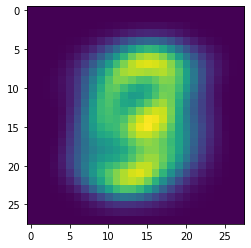

In [ ]:
plt.imshow(digit)

In [ ]:
zd = Encd(digit.reshape(1, 1, 784))[2]

In [ ]:
zd

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.14654562, -0.06999511, -0.06014408,  0.19976884,  0.16494924]],
      dtype=float32)>